# 3D-Bildsegmentierung
Die Bildsegmentierung in 3D ist aus mehreren Gründen herausfordernd: Bei vielen mikroskopischen Bildgebungsverfahren variiert die Bildqualität im Raum: Beispielsweise verschlechtert sich die Intensität und/oder der Kontrast, je tiefer man in eine Probe hineinbildet. Darüber hinaus sind sich berührende Zellkerne schwer automatisiert zu unterscheiden. Nicht zuletzt ist die Anisotropie je nach angewandten Algorithmen und entsprechenden gegebenen Parametern schwierig zu handhaben. Einige Algorithmen, wie der hier gezeigte [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb)-Ansatz, funktionieren nur für isotrope Daten.

In [1]:
from skimage.io import imread
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

import napari
from napari.utils import nbscreenshot

# For 3D processing, powerful graphics
# processing units might be necessary
cle.select_device('TX')

<NVIDIA GeForce GTX 1650 with Max-Q Design on Platform: NVIDIA CUDA (1 refs)>

Um den Workflow zu demonstrieren, verwenden wir zugeschnittene und neu abgetastete Bilddaten aus der [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC032):
Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. Verfügbar unter http://dx.doi.org/10.1038/nmeth.2083

In [2]:
input_image = imread("../../data/BMP4blastocystC3-cropped_resampled_8bit.tif")

voxel_size_x = 0.202
voxel_size_y = 0.202
voxel_size_z = 1

Zu Visualisierungszwecken zeigen wir Intensitätsprojektionen entlang X, Y und Z.

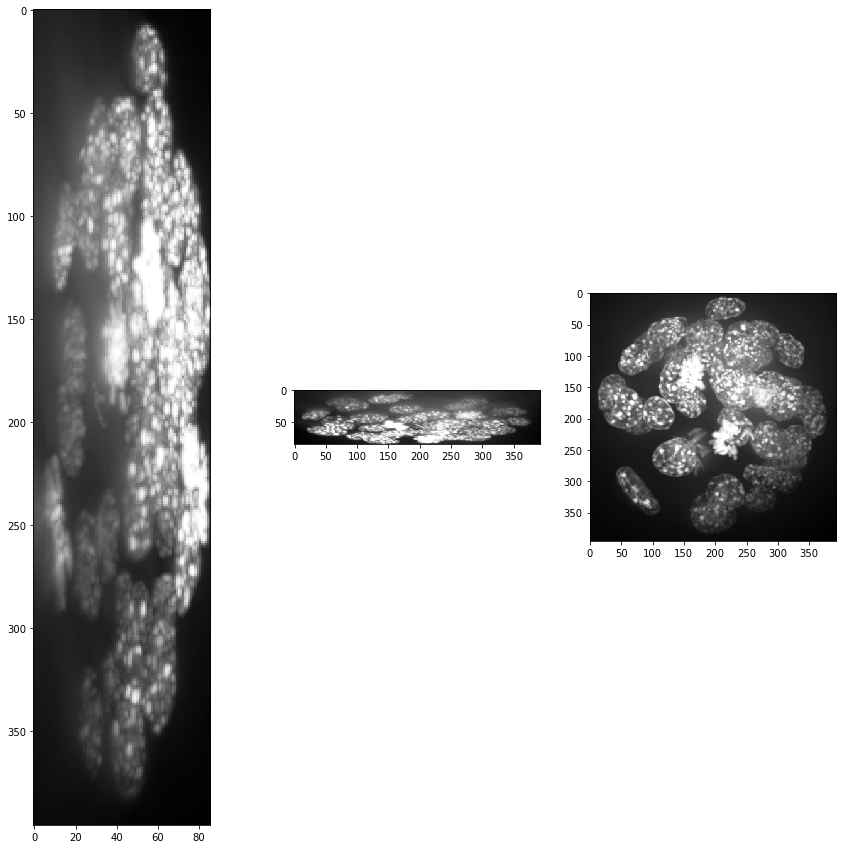

(86, 396, 393)


In [3]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.show()

show(input_image)
print(input_image.shape)

Offensichtlich ist die Voxelgröße nicht isotrop. Daher skalieren wir das Bild mit der Voxelgröße als Skalierungsfaktor, um einen Bildstapel mit isotropen Voxeln zu erhalten.

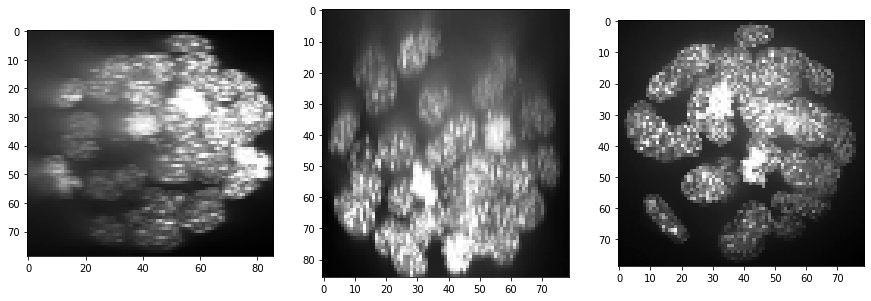

(86, 79, 79)


In [4]:
resampled = cle.scale(input_image, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, auto_size=True)

show(resampled)
print(resampled.shape)

## Intensitäts- und Hintergrundkorrektur
Wie wir sehen können, nimmt die Intensität in Z-Richtung (von Schicht zu Schicht) ab und der Kontrast ebenfalls. Zumindest der Intensitätsabfall kann korrigiert werden. In [CLIJx](https://github.com/clij/clijx) ist diese Methode als [equalize_mean_intensities_of_slices](https://clij.github.io/clij2-docs/reference_equalizeMeanIntensitiesOfSlices) bekannt.

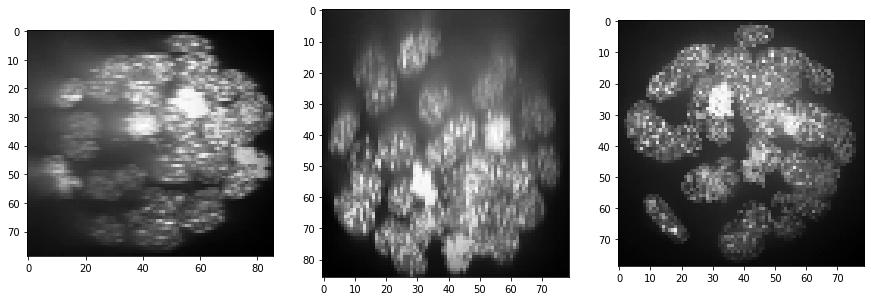

In [5]:
equalized_intensities_stack = cle.create_like(resampled)
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])

num_slices = resampled.shape[0]
mean_intensity_stack = cle.mean_of_all_pixels(resampled)

corrected_slice = None
for z in range(0, num_slices):
    # get a single slice out of the stack
    cle.copy_slice(resampled, a_slice, z)
    # measure its intensity
    mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
    # correct the intensity
    correction_factor = mean_intensity_slice/mean_intensity_stack
    corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
    # copy slice back in a stack
    cle.copy_slice(corrected_slice, equalized_intensities_stack, z)

show(equalized_intensities_stack)

Darüber hinaus scheint die Hintergrundintensität zuzunehmen, möglicherweise ein Ergebnis von mehr Streuung tief in der Probe. Wir können dies durch eine Hintergrundsubtraktionstechnik ausgleichen:

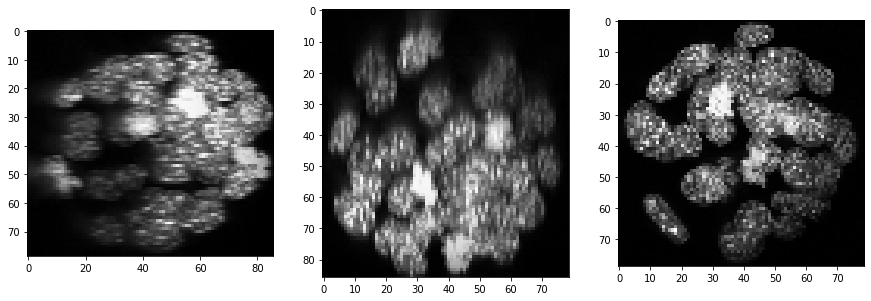

In [6]:
backgrund_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=5, radius_y=5, radius_z=5)
show(backgrund_subtracted)

## Segmentierung


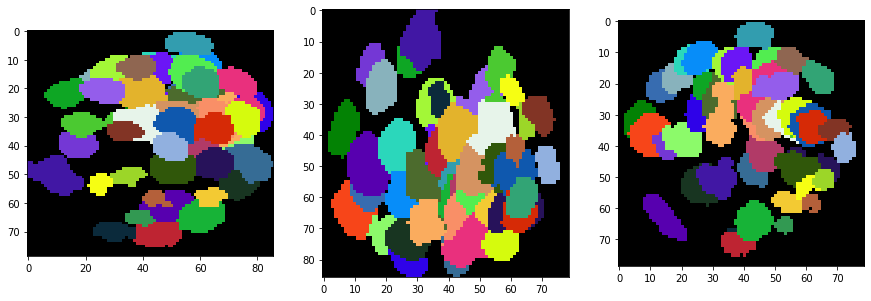

In [7]:
segmented = cle.voronoi_otsu_labeling(backgrund_subtracted, spot_sigma=3, outline_sigma=1)
show(segmented, labels=True)

Da Segmentierungsergebnisse in 3D schwer zu inspizieren sind, erzeugen wir einen Bildstapel mit den ursprünglichen Intensitäten + Umrissen der Segmentierung. Wir zeigen diesen Stapel für einige Schichten.

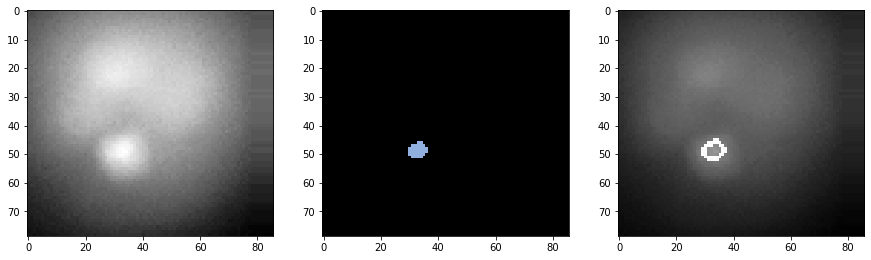

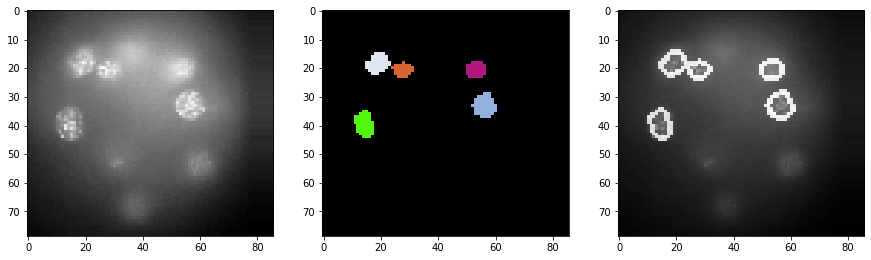

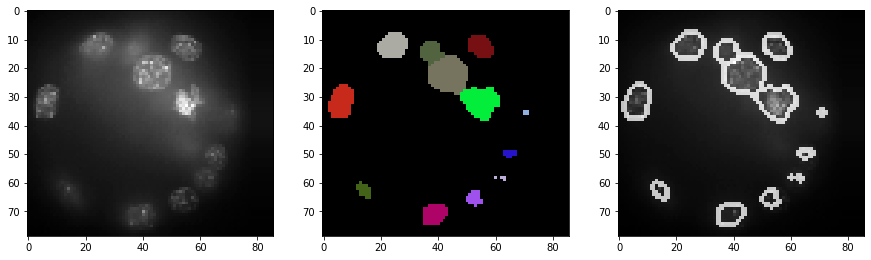

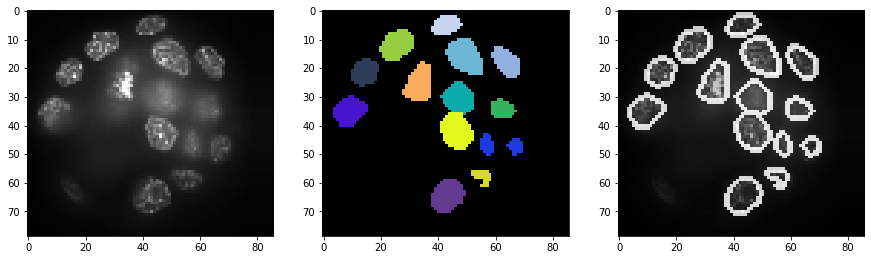

In [8]:
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])
segmented_slice = cle.create([resampled.shape[1], resampled.shape[0]])

for z in range(0, resampled.shape[2], 20):
    label_outlines = None
    combined = None

    # get a single slice from the intensity image and the segmented label image
    cle.copy_slice(resampled, a_slice, z)
    cle.copy_slice(segmented, segmented_slice, z)

    # determine outlines around labeled objects
    label_outlines = cle.detect_label_edges(segmented_slice, label_outlines)

    # combine both images
    outline_intensity_factor = cle.maximum_of_all_pixels(a_slice)
    combined = cle.add_images_weighted(a_slice, label_outlines, combined, 1.0, outline_intensity_factor)

    # visualisation
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(a_slice, plot=axs[0])
    cle.imshow(segmented_slice, plot=axs[1], labels=True)
    cle.imshow(combined, plot=axs[2])

## Visualisierung in 3D
Für die tatsächliche Visualisierung in 3D können Sie auch [napari](https://napari.org/) verwenden.

In [9]:
# start napari
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(resampled))
viewer.add_image(cle.pull(equalized_intensities_stack))
viewer.add_labels(cle.pull(segmented))

INFO:xmlschema:Resource 'XMLSchema.xsd' is already loaded


<Labels layer 'Labels' at 0x1eba6d51dc0>

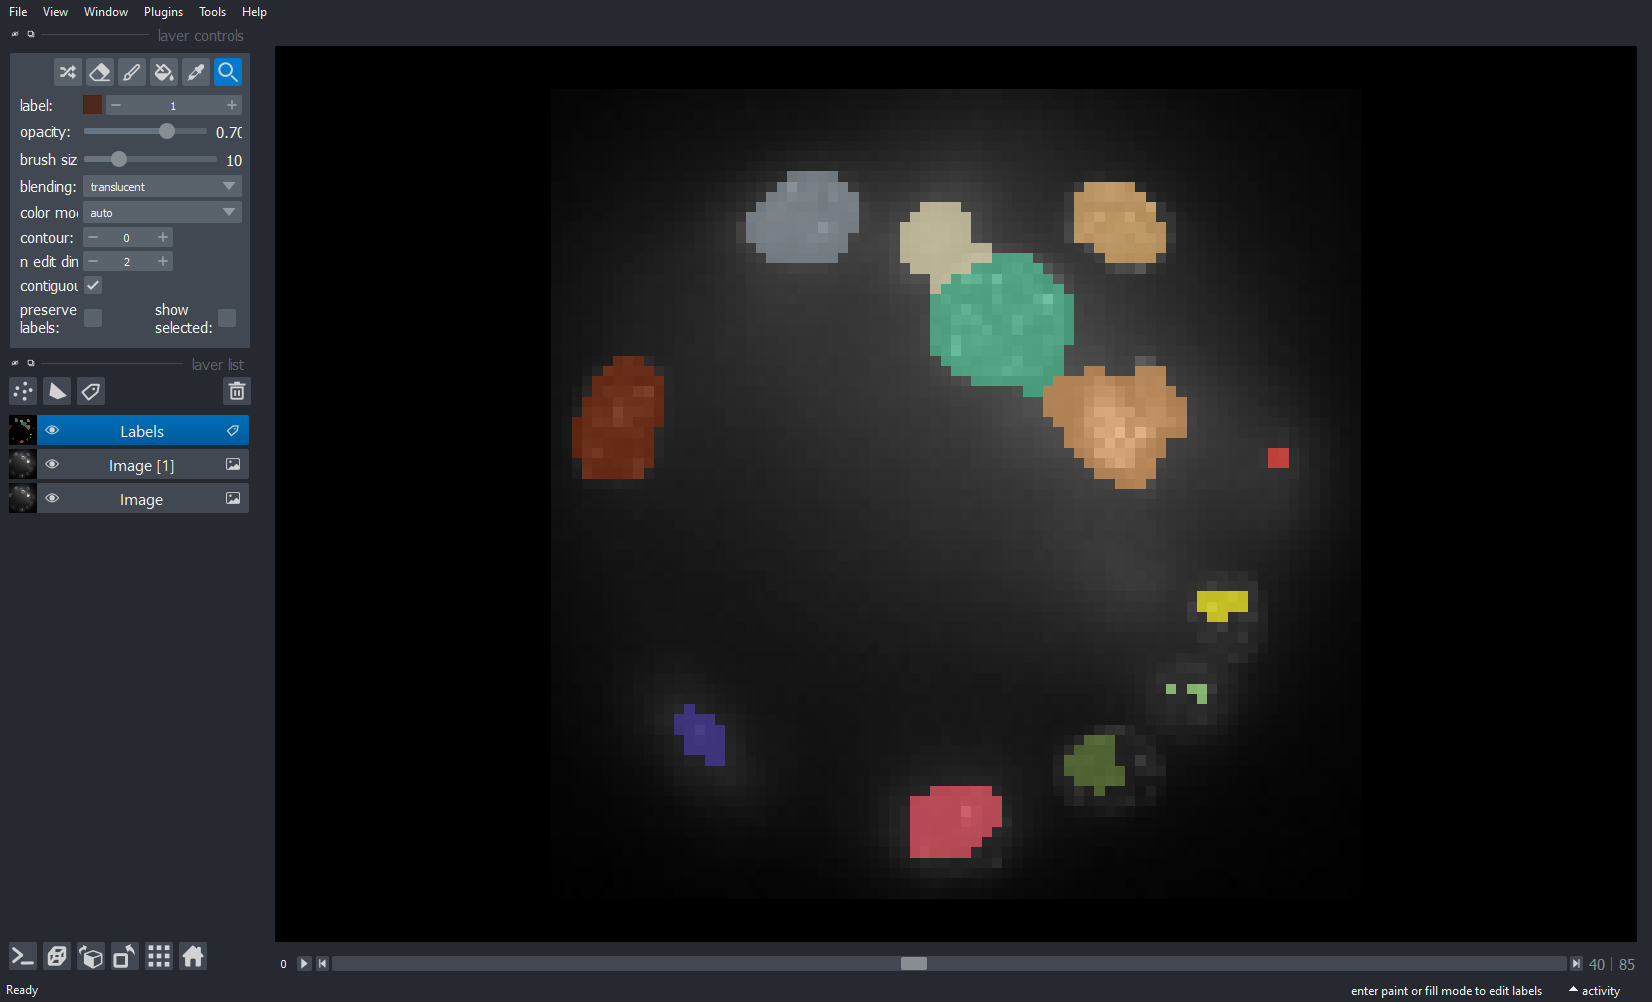

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [10]:
viewer.dims.current_step = (40, 0, 0)
nbscreenshot(viewer)

Wir können zur 3D-Ansicht wechseln, indem wir auf den 3D-Button in der unteren linken Ecke klicken.

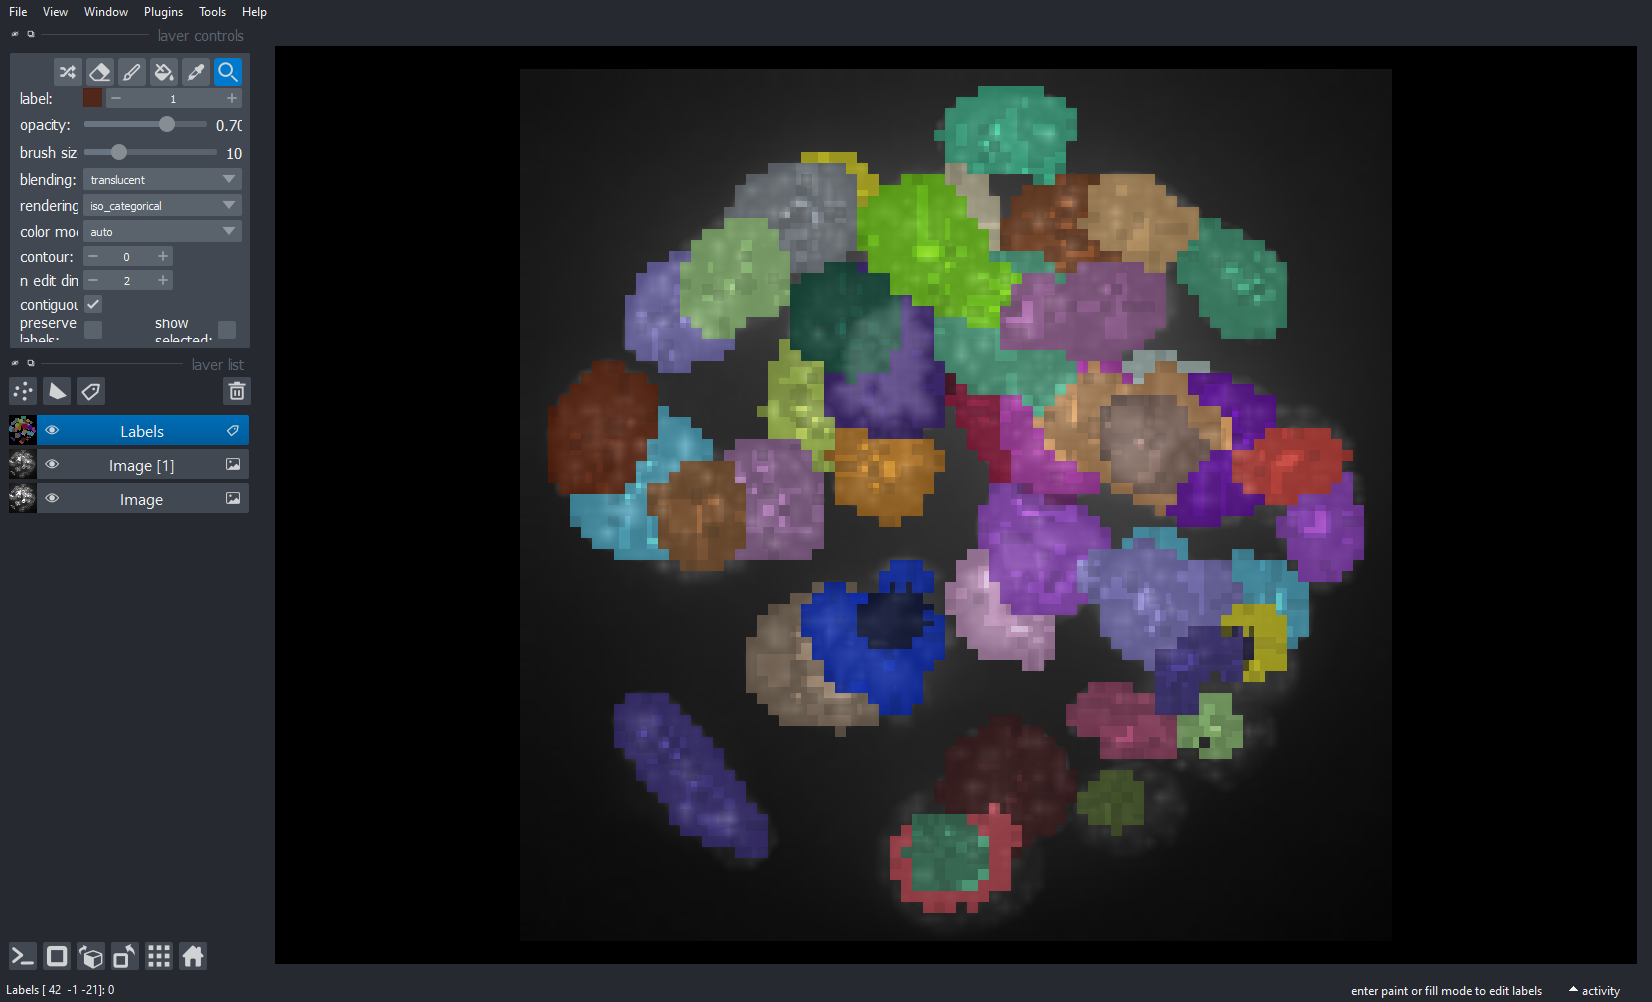

In [11]:
nbscreenshot(viewer)

Wir können dann auch die Ansicht kippen und neigen.

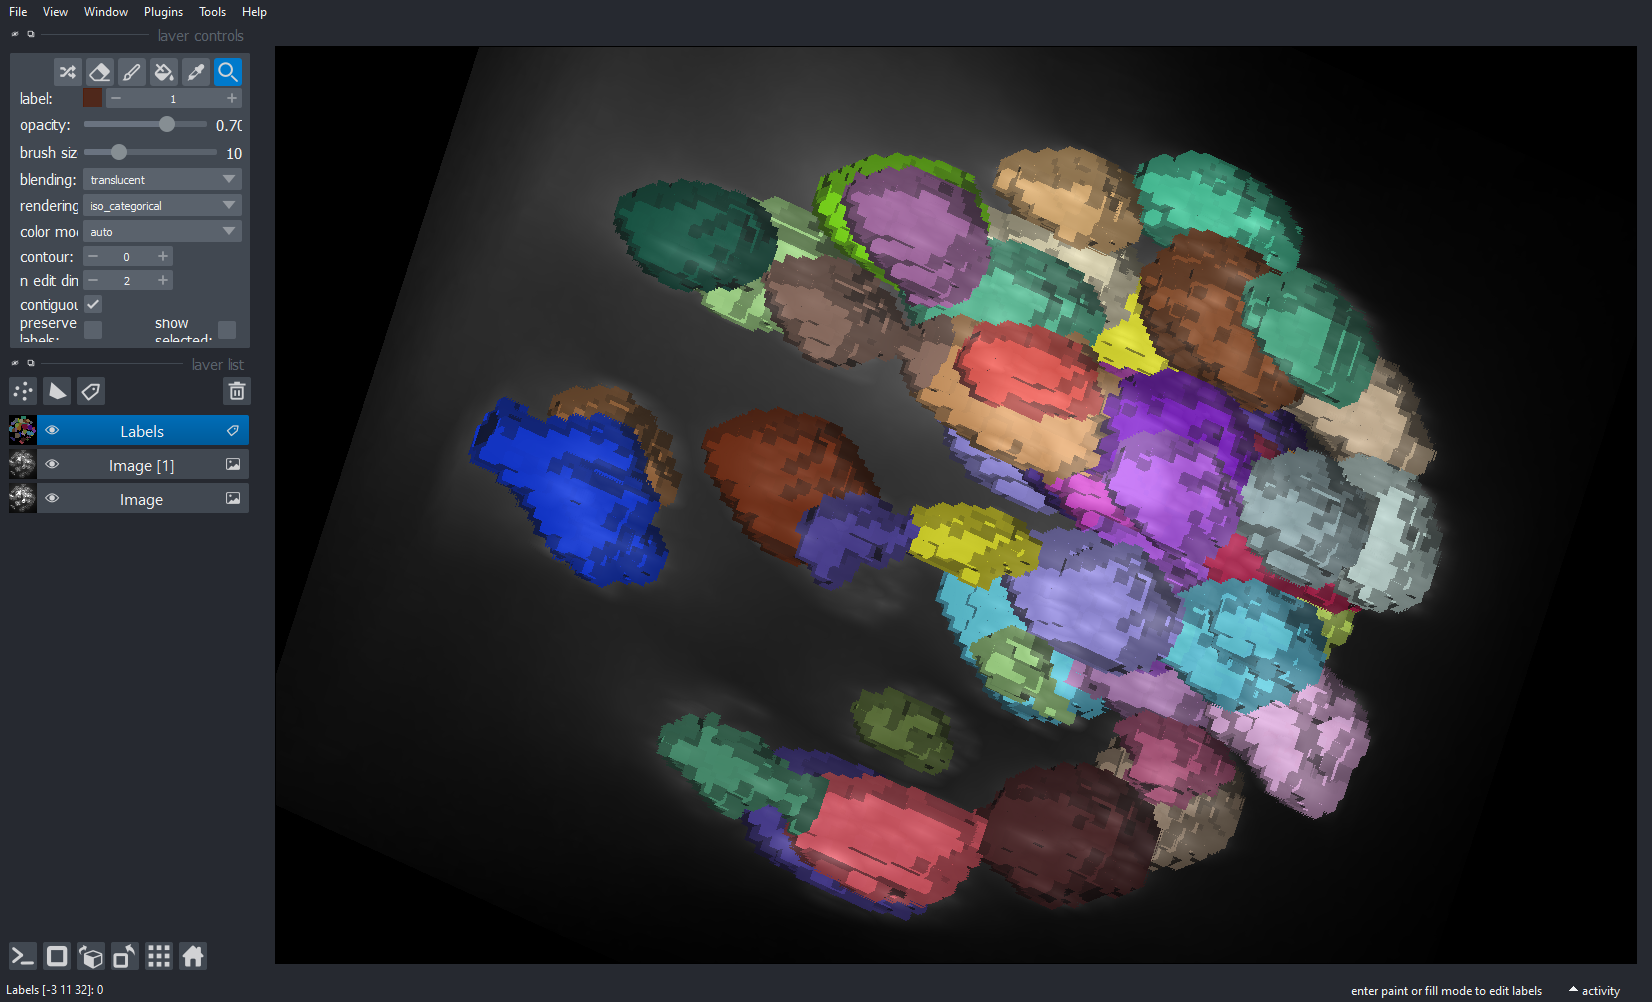

In [12]:
nbscreenshot(viewer)